# Insurance Cost Analysis
In this project, we will perform analytics operations on an insurance database that uses the below mentioned parameters.

| Parameter |Description| Content type |
|---|----|---|
|age| Age in years| integer |
|gender| Male or Female|integer (1 or 2)|
| bmi | Body mass index | float |
|no_of_children| Number of children | integer|
|smoker| Whether smoker or not | integer (0 or 1)|
|region| Which US region - NW, NE, SW, SE | integer (1,2,3 or 4 respectively)| 
|charges| Annual Insurance charges in USD | float|



### Import Required Libraries

In [1]:
import piplite
await piplite.install('seaborn')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split

### Import the Dataset

In [3]:
from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, "wb") as f:
            f.write(await response.bytes())

In [4]:
filepath = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/medical_insurance_dataset.csv'

In [5]:
await download(filepath, "insurance.csv")
file_name="insurance.csv"

In [6]:
df = pd.read_csv(file_name)

In [7]:
df.head()

,19,1,27.9,0,1.1,3,16884.924
0,18,2,33.770,1,0,4,1725.55230
1,28,2,33.000,3,0,4,4449.46200
2,33,2,22.705,0,0,1,21984.47061
3,32,2,28.880,0,0,1,3866.85520
4,31,1,25.740,0,?,4,3756.62160


## Data Wrangling

As you see the dataset does not have headers. So, we will add columns the parameters which have been mentioned above in description.

In [8]:
headers = ["age", "gender", "bmi", "no_of_children", "smoker", "region", "charges"]
df.columns = headers

In [15]:
df.head()

,age,gender,bmi,no_of_children,smoker,region,charges
0,18,2,33.770,1,0,4,1725.55230
1,28,2,33.000,3,0,4,4449.46200
2,33,2,22.705,0,0,1,21984.47061
3,32,2,28.880,0,0,1,3866.85520
4,31,1,25.740,0,?,4,3756.62160


There is a '?' in 4th row and it means that our dataset contains non values. In ordet to check it, we will firstly convert '?' to non-values.

In [17]:
df.replace('?', np.nan, inplace= True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2767 non-null   object 
 1   gender          2771 non-null   int64  
 2   bmi             2771 non-null   float64
 3   no_of_children  2771 non-null   int64  
 4   smoker          2764 non-null   object 
 5   region          2771 non-null   int64  
 6   charges         2771 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 130.0+ KB


We have missing values in 'age' and 'smoker' column. We will handle with missing data with the following steps:

- For continuous attributes (e.g., age), replace missing values with the mean.
- For categorical attributes (e.g., smoker), replace missing values with the most frequent value.
- Update the data types of the respective columns.
- Verify the update using `df.info()`.

In [19]:
# smoker is a categorical attribute, replace with most frequent entry
is_smoker = df['smoker'].value_counts().idxmax()
df["smoker"].replace(np.nan, is_smoker, inplace=True)

# age is a continuous variable, replace with mean age
mean_age = df['age'].astype('float').mean(axis=0)
df["age"].replace(np.nan, mean_age, inplace=True)

# Update data types
df[["age","smoker"]] = df[["age","smoker"]].astype("int")

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2771 non-null   int32  
 1   gender          2771 non-null   int64  
 2   bmi             2771 non-null   float64
 3   no_of_children  2771 non-null   int64  
 4   smoker          2771 non-null   int32  
 5   region          2771 non-null   int64  
 6   charges         2771 non-null   float64
dtypes: float64(2), int32(2), int64(3)
memory usage: 130.0 KB
None


Also note, that the `charges` column has values which are more than 2 decimal places long. Update the `charges` column such that all values are rounded to nearest 2 decimal places.

In [21]:
df[["charges"]] = np.round(df[["charges"]],2)
df.head()

,age,gender,bmi,no_of_children,smoker,region,charges
0,18,2,33.770,1,0,4,1725.55
1,28,2,33.000,3,0,4,4449.46
2,33,2,22.705,0,0,1,21984.47
3,32,2,28.880,0,0,1,3866.86
4,31,1,25.740,0,0,4,3756.62


## Exploratory Data Analysis
Implement the regression plot for `charges` with respect to `bmi`.

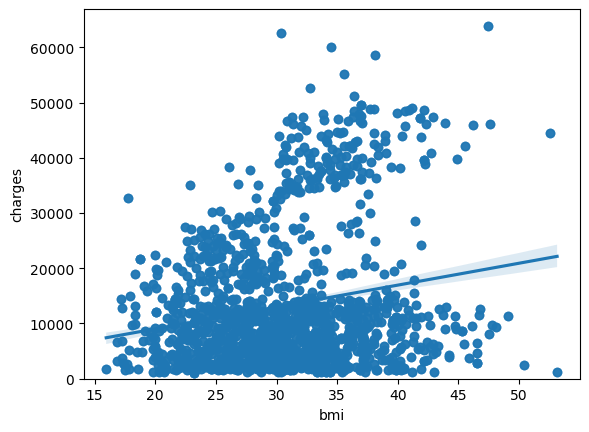

In [24]:
sns.regplot(x='bmi', y='charges', data=df)
plt.ylim(0,);

Implement the box plot for `charges` with respect to `smoker`.

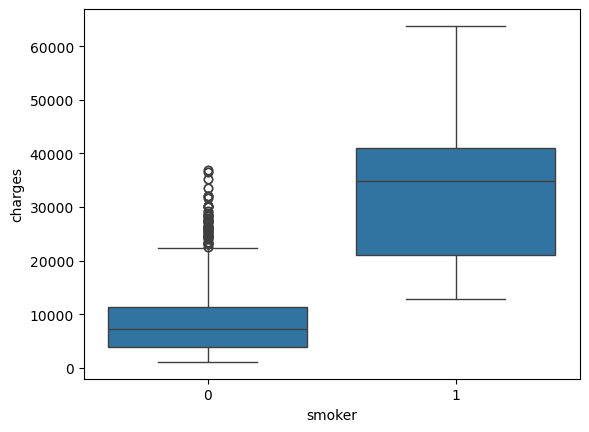

In [25]:
sns.boxplot(x='smoker', y='charges', data=df);

Print the correlation matrix for the dataset

In [27]:
df.corr()

,age,gender,bmi,no_of_children,smoker,region,charges
age,1.000000,-0.026584,0.112859,0.037126,-0.022290,-0.006969,0.298892
gender,-0.026584,1.000000,0.042766,0.015693,0.083125,0.022360,0.062959
bmi,0.112859,0.042766,1.000000,-0.001642,0.011824,0.271200,0.199906
no_of_children,0.037126,0.015693,-0.001642,1.000000,0.007016,-0.025594,0.066551
smoker,-0.022290,0.083125,0.011824,0.007016,1.000000,0.053839,0.789141
region,-0.006969,0.022360,0.271200,-0.025594,0.053839,1.000000,0.054018
charges,0.298892,0.062959,0.199906,0.066551,0.789141,0.054018,1.000000


## Model Development
Fit a linear regression model that may be used to predict the `charges` value, just by using the `smoker` attribute of the dataset. Print the $ R^2 $ score of this model.
.

In [28]:
lm = LinearRegression()
X = df[['smoker']]
Y = df['charges']
lm.fit(X,Y)
print(lm.score(X,Y))

0.6227430402464125


Fit a linear regression model that may be used to predict the `charges` value, just by using all other attributes of the dataset. Print the $ R^2 $ score of this model.

In [29]:
# definition of Y and lm remain same as used in last cell. 
Z = df[["age", "gender", "bmi", "no_of_children", "smoker", "region"]]
lm.fit(Z,Y)
print(lm.score(Z, Y))

0.7505888664568174


As you see, the R^2 of multiple linear regression 0.75 is higher than the simple 0.622 and it means that with multiple linear regresion we have an improvement in our model. 

Write a training pipeline that uses `StandardScaler()`, `PolynomialFeatures()` and `LinearRegression()` to generate a model that can predict the `charges` value using all the other attributes of the dataset.

In [30]:
# Y and Z use the same values as defined in previous cells 
Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(include_bias=False)), ('model', LinearRegression())]
pipe=Pipeline(Input)
Z = Z.astype(float)
pipe.fit(Z,Y)
ypipe=pipe.predict(Z)
print(r2_score(Y,ypipe))

0.8453681600043882


Now, we have even further improvement with pipeline in our model as you see the R^2 of it is 0.845.

## Model Refinement

Split the data into training and testing subsets, assuming that 20% of the data will be reserved for testing.

In [31]:
# Z and Y hold same values as in previous cells
x_train, x_test, y_train, y_test = train_test_split(Z, Y, test_size=0.2, random_state=1)

Initialize a Ridge regressor that used hyperparameter $ \alpha = 0.1 $. Fit the model using training data data subset. Print the $ R^2 $ score for the testing data.

In [32]:
# x_train, x_test, y_train, y_test hold same values as in previous cells
RidgeModel=Ridge(alpha=0.1)
RidgeModel.fit(x_train, y_train)
yhat = RidgeModel.predict(x_test)
print(r2_score(y_test,yhat))

0.7254198858412217


Apply polynomial transformation to the training parameters with degree=2. Use this transformed feature set to fit the same regression model, as above, using the training subset. Print the $ R^2 $ score for the testing subset.

In [33]:
# x_train, x_test, y_train, y_test hold same values as in previous cells
pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)
RidgeModel.fit(x_train_pr, y_train)
y_hat = RidgeModel.predict(x_test_pr)
print(r2_score(y_test,y_hat))

0.8208413195172275
